In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,CCATTTCCCACACGAGAGCCCGGCTTTCCTGTCACATTTGGTAAGG...,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...
9736,TTGATAGGTCATTTACGGCGCGCGAGCCGCATAGGGTAGTAGGGAT...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9737,GTTAGTGACCTAGCCGGGCTATTGGCGAGACTTACCTAACGGAGTT...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,CTGTTCAGACGACGATATACGGCCCTGCATTGTATTGTAAAAGCGT...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 41931.80it/s]


[7178, 7128, 7159, 7196, 7182, 7138, 7189, 7162, 7130, 7233, 7239, 7242, 7255, 7108, 7186, 7141, 7222, 7171, 7152, 7258, 7202, 7215, 7229, 7289, 7192, 7204, 7161, 7172, 7215, 7163, 7200, 7143, 7213, 7140, 7203, 7190, 7213, 7175, 7232, 7176, 7166, 7253, 7252, 7107, 7174, 7128, 7270, 7199, 7172, 7222, 7195, 7224, 7138, 7139, 7195, 7152, 7233, 7261, 7241, 7239, 7200, 7211, 7234, 7169, 7236, 7142, 7178, 7179, 7169, 7205, 7284, 7192, 7225, 7170, 7212, 7141, 7193, 7212, 7268, 7191, 7286, 7186, 7204, 7204, 7142, 7213, 7200, 7236, 7147, 7134, 7241, 7169, 7227, 7196, 7210, 7137, 7139, 7229, 7205, 7263, 7155, 7144, 7181, 7234, 7226, 7205, 7125, 7118, 7059, 6400]


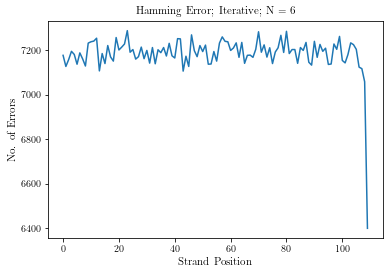

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:18<00:00, 530.81it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


TTT -> GG 6
 -> GATAA 6
 -> GAGAG 6
 -> GCCCC 6
 -> GCCAG 6
 -> ATCCT 6
 -> CCAAC 6
 -> CATAA 6
 -> AAATC 6
 -> ATCCC 6
TTTCG ->  6
TTTTA ->  6
 -> CATG 6
 -> ACAAC 6
 -> ACATT 6
 -> GAAGG 6
 -> AGACC 6
 -> ATTGA 6
 -> AAAAG 6
 -> CGTCT 6
 -> CGTGG 6
 -> GAGTG 6
 -> CGAGG 6
 -> AGGAG 6
 -> AGAGT 6
 -> CGCGC 6
 -> AATACT 6
 -> AGCCC 6
 -> AGGTT 6
 -> ATATT 6
 -> CCGCC 6
 -> CCGAC 6
 -> AGGGC 6
 -> ACGCG 6
 -> GAGTA 6
 -> ATCTC 6
 -> AAGGT 6
 -> AAGGG 6
 -> CGGCG 6
 -> CACCA 6
 -> CGGCC 6
 -> AAGAG 6
 -> AGGTA 6
TTTTG ->  6
 -> CCCCA 6
 -> CCCAA 6
TTT -> AA 6
 -> CGGCT 6
 -> GATTA 6
 -> AATTT 6
 -> CAACA 6
 -> AGATA 6
 -> GATGA 6
 -> CCTGG 6
 -> AGATG 6
 -> CGGGG 6
 -> GATGAA 6
 -> AATTA 6
 -> GCCGC 6
 -> CAGCG 6
 -> CCCCG 6
TTGGG ->  6
 -> GAAGA 6
 -> CCTAT 6
 -> AATGA 6
 -> GACACA 6
 -> ACCCC 6
 -> CAGAC 6
 -> CTTCT 6
 -> CACGG 6
 -> CTCCT 6
TTGTG ->  6
TCATA ->  6
C -> GAT 6
GAAAA ->  6
TATTA ->  6
TT -> GAG 6
G -> TTTT 6
 -> TTCTG 6
G -> TCTT 6
 -> TTGGG 6
 -> TTGTG 6
G -> CTTC 6
G -

CC ->  @ 5 6
GT ->  @ 53 6
G -> C @ 2 6
 -> TG @ 49 6
 -> TG @ 74 6
G -> C @ 25 6
AA ->  @ 14 6
CC ->  @ 97 6
 -> TG @ 39 6
C -> A @ 13 6
CC ->  @ 41 6
 -> CA @ 47 6
 -> CA @ 41 6
C -> A @ 11 6
G -> C @ 31 6
 -> TT @ 60 6
TG ->  @ 75 6
A -> T @ 16 6
G -> C @ 26 6
 -> TT @ 97 6
G -> T @ 30 6
 -> TT @ 96 6
 -> TA @ 36 6
G -> T @ 16 6
 -> TA @ 37 6
CC ->  @ 27 6
A -> T @ 26 6
AA ->  @ 102 6
AA ->  @ 100 6
CC ->  @ 83 6
G -> C @ 11 6
GT ->  @ 84 6
CC ->  @ 16 6
CC ->  @ 69 6
 -> CGC @ 8 6
CC ->  @ 7 6
G -> T @ 100 6
 -> CA @ 33 6
CC ->  @ 81 6
 -> CA @ 8 6
CC ->  @ 79 6
 -> TG @ 72 6
G -> C @ 100 6
 -> CA @ 35 6
G -> C @ 103 6
 -> CCG @ 8 6
 -> CA @ 53 6
 -> TT @ 71 6
AA ->  @ 10 6
CT -> G @ 110 6
 -> TG @ 62 6
 -> TG @ 6 6
G -> T @ 15 6
CC ->  @ 26 6
AA ->  @ 109 6
 -> TA @ 27 6
 -> AAA @ 18 6
A -> C @ 101 6
A -> T @ 27 6
A -> T @ 103 6
 -> CA @ 75 6
G -> T @ 107 6
TCC ->  @ 48 6
 -> AAA @ 2 6
 -> AA @ 95 6
 -> TT @ 90 6
 -> CA @ 31 6
CC ->  @ 85 6
 -> TT @ 89 6
 -> CA @ 5 6
 -> TA @ 65 6

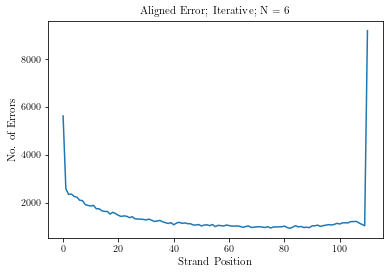

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[225, 53, 60, 77, 74, 60, 61, 73, 46, 49, 42, 47, 43, 39, 37, 48, 40, 36, 41, 44, 28, 39, 39, 32, 39, 39, 26, 34, 30, 23, 22, 35, 23, 25, 36, 21, 25, 27, 25, 31, 28, 22, 30, 27, 27, 22, 19, 15, 15, 29, 22, 23, 18, 21, 23, 21, 28, 23, 21, 22, 19, 20, 23, 18, 17, 21, 22, 29, 20, 17, 26, 24, 15, 17, 18, 19, 28, 17, 25, 22, 20, 23, 17, 16, 27, 19, 22, 22, 25, 19, 14, 22, 17, 25, 23, 27, 28, 19, 24, 27, 31, 23, 33, 25, 29, 45, 36, 33, 27, 47, 44]
[165, 46, 64, 72, 68, 72, 55, 54, 56, 50, 49, 44, 49, 51, 45, 41, 44, 27, 33, 26, 42, 35, 45, 34, 25, 34, 39, 36, 26, 36, 29, 31, 28, 32, 24, 24, 28, 28, 17, 31, 22, 18, 18, 28, 31, 26, 26, 24, 19, 19, 22, 21, 15, 20, 18, 17, 22, 21, 20, 18, 24, 23, 30, 22, 25, 22, 26, 18, 20, 19, 23, 27, 25, 21, 16, 20, 25, 17, 19, 23, 21, 26, 21, 21, 20, 27, 16, 21, 13, 18, 11, 22, 18, 18, 33, 27, 28, 31, 22, 26, 33, 32, 29, 23, 24, 36, 27, 22, 33, 54, 71]
[210, 48, 65, 60, 54, 56, 55, 57, 62, 53, 44, 46, 46, 37, 50, 38, 51, 32, 33, 37, 30, 35, 39, 28, 27, 30, 35

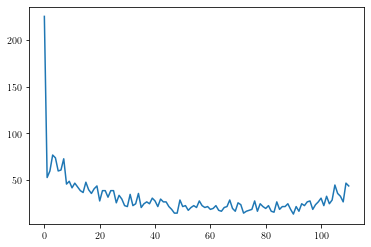

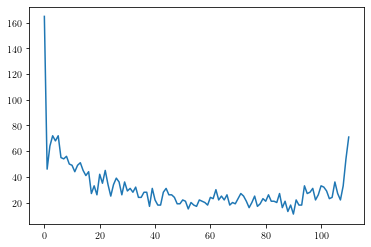

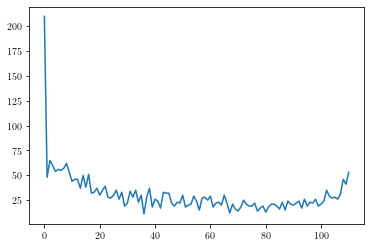

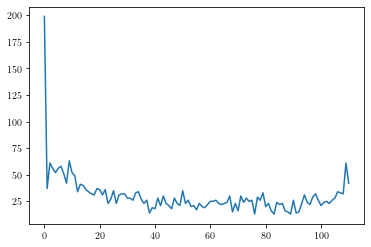

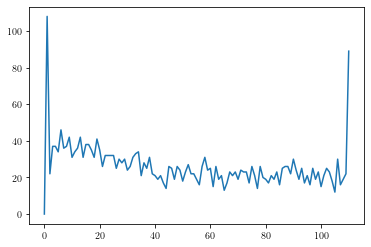

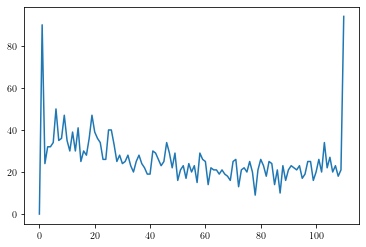

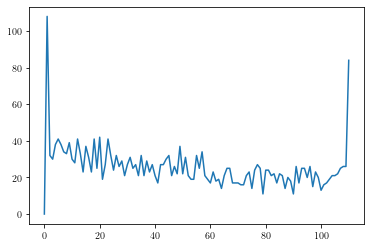

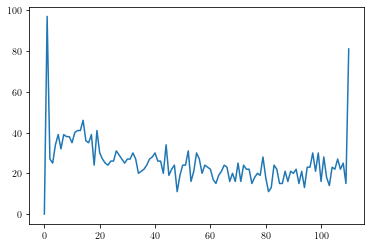

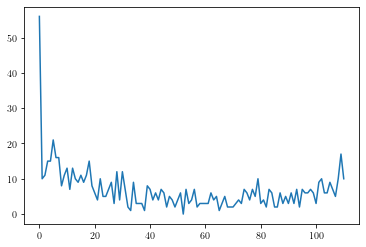

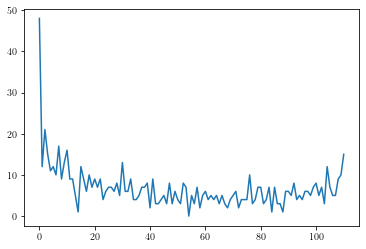

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)